# <span style="color:skyblue;"> Seq2seq로 한/영 번역기 만들기</span>

Korean-English 사이 번역 데이터 corpus를 활용하여 번역 태스크를 수행

<span style='color:skyblue;'> **모델 : Bahdanau attention 스타일의 seq2seq**</span>

초반 시행에서 어텐션 시각화 과정에 있어 실수로 한글 및 영문 문자열이랑 시각화랑 일치하지 않는 문제가 있었는데 발견 못하고 있다가 후반에 수정함

그래도 어느정도 이번 프로젝트 문제를 해결한 듯

### 예문 출력 결과

    Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
    Predicted translation: seven people were also died , who was killed . <end> 
    
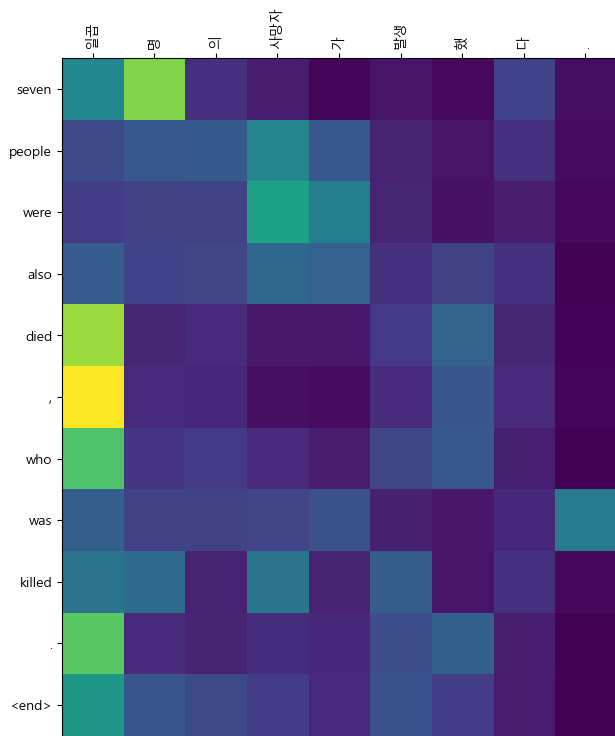    

    Input: ['커피', '는', '필요', '없', '다', '.']
    Predicted translation: the drink changes should be on instead of coffee <end> 

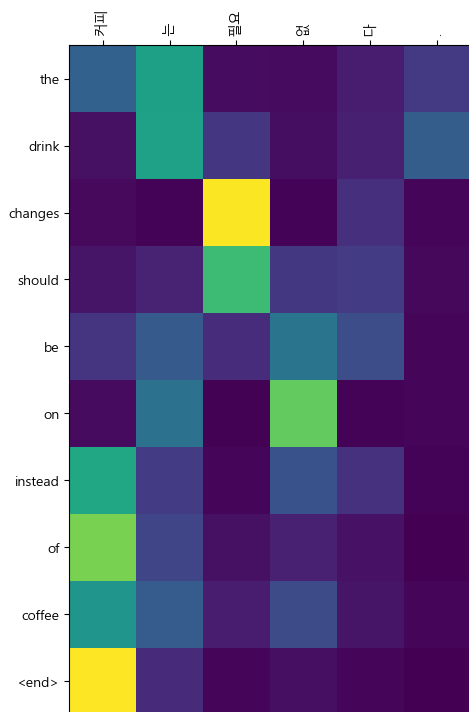

    Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
    Predicted translation: they have a living in the city . <end> 
    
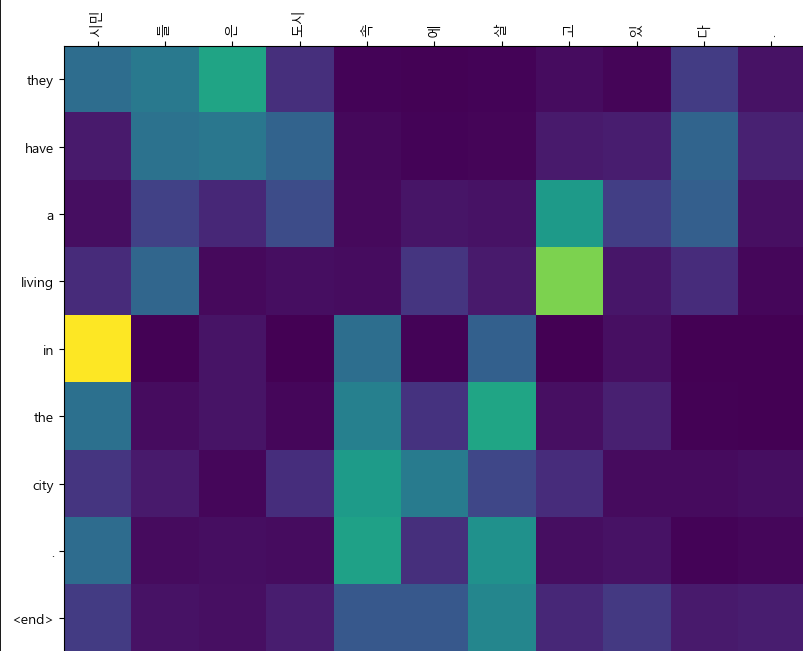


## <span style="color:#FF0000;"> 시행 1부터 8까지 밑의 모든 결과 이미지는 잘못 됨</span>

어텐션 계산을, 형태소 기반 해체 후에 morph 기반으로 했어야 하는데 멍청하게 sentence.split 한 거를 사용하고 있었음

이러니까 모델이 inference를 못 하지

어떻게 보면 아예 잘못된 토큰들을 가지고 어텐션을 계산했는데 어찌저찌 맞추려고 노력하고 있던 거였을거임 모델은 .. 

### 시행 9: 한국어 토큰을 제대로 하고 epoch 20회
BATCH_SIZE     = 32
KO_VOCAB_SIZE = 25000
EN_VOCAB_SIZE = 15000
units         = 384
embedding_dim = 192

기법 적용:
- Padding Mask = True
- Repetition Penalty = 2 (throughout the entire sequence)
- Dropout = 0.3 (Encoder, Decoder)
- Softmax Temperature = 1.3
- Mecab Tokenizing while Inference : 핵심!!!!!!!!!!!

### 훈련 시 loss 감소 양상

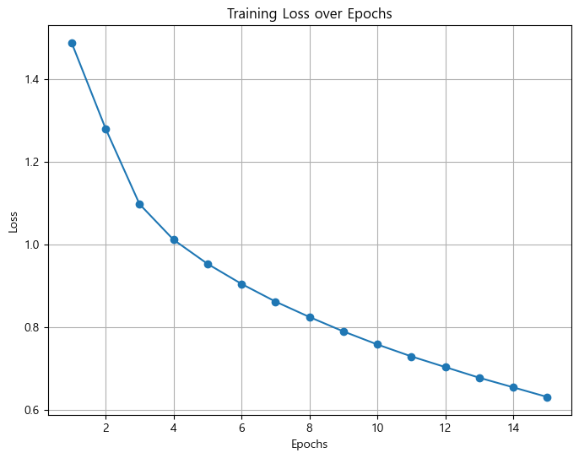

## 이하 무의미한 결과 기록(시행1~8) + 이미지 깨져서 삭제

The Frozens: 시행1~3
- Batch size = 32
- Optimizer = Adam
- Loss = Sparse Categorical Crossentropy
- Vocab size = 15000

### 시행 1: (소요 시간: 1h 43m 4s)
Hyperparameters
- GRU units         = 128
- embedding_dim = 128
- max sequence length = 30
- Dropout = None
- Padding Mask = None

결과: 처참하다


### 시행 2: 역시 처참하다 (소요 시간: 1h 42m 59s)
- Padding Mask = True


어텐션에서 패딩과 관련한 문제를 해결했다고 생각했는데 여전히 blank를 참조한다...?

### 시행 3: Dropout 추가, 여전하다
- Dropout rate: 0.3
- Dropout position: after embedding, after GRU

왜 unk 토큰들이 반복해서 출력되는가? 아마 형태소 단위로 mecab이 토크나이징 하고 있는데, vocab_size가 15000이라서 형태소 등이 모두 잘려나가는 것이 아닐까?

또한 왜 end 토큰을 예측하지 못 하는 걸까? 문장이 마쳐야 할 타이밍을 못 잡고 계속에서 max len까지 출력을 생성하고 있다.


### 시행 4: 
- GRU units = 384
- embedding_dim = 192
- Vocab_size 3만으로 증가
- FP16 mixed precision 사용
- Mixed precision에 따른 메모리 여유로 Batch size 64로 증가

### 시행 5: 
- Batch size = 32
- GRU units = 512... 로 하려고 했으나 OOM 이라서 다시 급하게 384로
- padding length = 60에서 truncate


### 시행 6: Repetition penalty 직전 5단어까지 추가
- Repetition penalty ratio : 1.5
- 시행 5 모델 fine tuning 5회


### 시행 7: Repetition penalty를 2까지 늘리고, 전체 토큰에 대해서 중복방지 적용
- 시행 6 모델 fine tuning 5회


### 시행 8: 처음부터 다시 수행, softmax temp 1.5 주입
- kor vocab size = 25000으로 감소
- en vocab size = 15000으로 감소!


## 이하 모델 코딩

#### 라이브러리 호출

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re # 정규식

In [ ]:
from tensorflow.keras import mixed_precision

# Mixed Precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(policy)


#### 파일 불러오기
Link: [깃허브](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

확장자 txt 로 변환 후 진행

In [ ]:
filepath = 'C:/datasets_temp/korean-parallel-corpora-master/korean-english-news-v1/korean-english-park'

ko_train_path = filepath + '.train-ko.txt'
en_train_path = filepath + '.train-en.txt'
ko_test_path = filepath + '.test-ko.txt'
en_test_path = filepath + '.test-en.txt'

ko_train = open(ko_train_path, 'r', encoding='utf-8').readlines()
en_train = open(en_train_path, 'r', encoding='utf-8').readlines()
ko_test = open(ko_test_path, 'r', encoding='utf-8').readlines()
en_test = open(en_test_path, 'r', encoding='utf-8').readlines()

#### 중복 제거를 위한 개수 확인

In [ ]:
print(len(ko_train))
print(len(en_train))
print(len(ko_test))
print(len(en_test))

아마 같은 문장을 다른 문장구조로 번역한 케이스가 있는 듯 함. 개수가 서로 다르네
"""
ko_train = list(set(ko_train))  
en_train = list(set(en_train))  
ko_test = list(set(ko_test))  
en_test = list(set(en_test))  

print(len(ko_train))  
print(len(en_train))  
print(len(ko_test))  
print(len(en_test))  
___
77591  
75598  
1995  
1942  
"""

쌍으로 묶은 뒤에 중복을 제거하는 방식 적용

In [ ]:
train = [(ko_train[x], en_train[x]) for x in range(len(ko_train))]
test = [(ko_test[x], en_test[x]) for x in range(len(ko_test))]

In [ ]:
train = list(set(train))
test = list(set(test))

In [ ]:
print(len(train))
print(len(test))

#### Cleaned corpus 생성

In [ ]:
ko_train, en_train = zip(*train)
ko_test, en_test = zip(*test)

ko_train = list(ko_train)
en_train = list(en_train)
ko_test = list(ko_test)
en_test = list(en_test)

In [ ]:
ko_train[:10]

In [ ]:
en_train[:10]

### 데이터 전처리

In [ ]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,\s]+", " ", sentence)

    sentence = " ".join(sentence.split())

    if s_token:
        sentence = "<start> " + sentence
    if e_token:
        sentence += " <end>"

    return sentence

In [ ]:
ko_train = [preprocess_sentence(x) for x in ko_train]
en_train = [preprocess_sentence(x, s_token=True, e_token=True) for x in en_train]

ko_test = [preprocess_sentence(x) for x in ko_test]
en_test = [preprocess_sentence(x, s_token=True, e_token=True) for x in en_test]

In [ ]:
ko_train[-10:]

In [ ]:
en_train[-10:]

In [ ]:
ko_test[:3]

In [ ]:
en_test[:3]

### 토크나이징:
영어: 스타트 엔드 토큰은 이미 추가했고, split을 활용해 이미 나누었음. 그래서 띄어쓰기로 그냥 필터링 해서 토크나이징 하면 될 듯

한국어: mecab 클래스를 이용해서 형태소 분석 기반 토크나이징 ㄱㄱ

단어 개수는 Top_k=15000으로 시작

In [ ]:
ko_top_k = 25000
en_top_k = 15000

In [ ]:
def tokenize_en(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=en_top_k, filters='', oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)

    tokenizer.word_index = {word: index for word, index in tokenizer.word_index.items() if index < en_top_k}
    tokenizer.index_word = {index: word for word, index in tokenizer.word_index.items()}
    
    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=60, padding='post')

    return tensor, tokenizer

In [ ]:
# Tokenizing Train
en_tensor, en_tokenizer = tokenize_en(en_train)

# Tokenizing Test
en_test_corpus, en_test_tokenizer = tokenize_en(en_test)

In [ ]:
len(en_tokenizer.index_word)

In [ ]:
from konlpy.tag import Mecab

In [ ]:
mecab = Mecab(dicpath = 'C:/Mecab/mecab-ko-dic')

def tokenize_ko(corpus):
    tokenized_corpus = [" ".join(mecab.morphs(sentence)) for sentence in corpus]
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=ko_top_k, filters='', oov_token="<unk>")
    tokenizer.fit_on_texts(tokenized_corpus)
    
    tokenizer.word_index = {word: index for word, index in tokenizer.word_index.items() if index < ko_top_k}
    tokenizer.index_word = {index: word for word, index in tokenizer.word_index.items()}

    tensor = tokenizer.texts_to_sequences(tokenized_corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=60, padding='post')

    return tensor, tokenizer


In [ ]:
# Tokenizing Train
ko_tensor, ko_tokenizer = tokenize_ko(ko_train)

# Tokenizing Test
ko_test_corpus, ko_test_tokenizer = tokenize_ko(ko_test)

In [ ]:
len(ko_tokenizer.index_word)

In [ ]:
len(en_tensor[3])

In [ ]:
len(en_tensor[0])

#### N개 이하의 토큰만 선별하기

In [ ]:
def get_real_length(tensor):
    return np.count_nonzero(tensor, axis=1)  # 0이 아닌 값의 개수만 세기

# 실제 길이 측정
ko_lengths = get_real_length(ko_tensor)
en_lengths = get_real_length(en_tensor)

In [ ]:
plt.hist(ko_lengths, bins=50)

In [ ]:
plt.hist(en_lengths, bins=50)

In [ ]:
filtered_indices = [i for i in range(len(ko_tensor)) if ko_lengths[i] <= 40 and en_lengths[i] <= 40]

# 실제 필터링 적용
kor_corpus = [ko_tensor[i] for i in filtered_indices]
eng_corpus = [en_tensor[i] for i in filtered_indices]

# 리스트로 변환
kor_corpus = np.array(kor_corpus)
eng_corpus = np.array(eng_corpus)

In [ ]:
print(len(kor_corpus))
print(len(kor_corpus))

### Attention Seq2seq 모델 정의하기

첫 번째 시도에는 패딩 마스크를 안 넣어서, 두 번째 시행에서는 패딩을 넣고 재시험

원래는 드랍아웃 유무를 테스트하려고 했으나 이슈가 생김

#### Bahdanau Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec, mask=None):
        """
        h_enc: [batch x length x units]
        h_dec: [batch x units]
        mask : [batch x length]  (0 for PAD, 1 for valid tokens)
        """

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))    
        
        if mask is not None:
            """
            mask shape: [batch x length]
            broadcast to [batch x length x 1] to match score shape
            """
            mask = tf.expand_dims(mask, axis=-1)
            score += (1.0 - mask) * -1e4
        
        temp = 1.3
        
        attn = tf.nn.softmax(score / temp , axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

#### Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(0.3)
		
    def call(self, x):
        out = self.embedding(x)
        out = self.dropout(out)
        out = self.gru(out)
        out = self.dropout(out)
        
        return out

#### Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.dropout = tf.keras.layers.Dropout(0.3)
        
        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out, enc_mask=None):
        context_vec, attn = self.attention(enc_out, h_dec, mask=enc_mask)
        """
        x:        [batch x 1]
        h_dec:    [batch x dec_units]
        enc_out:  [batch x sequence_len x enc_units]
        enc_mask: [batch x sequence_len], 0이면 PAD 토큰
        """
        out = self.embedding(x)
        out = self.dropout(out)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = self.dropout(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)
        
        return out, h_dec, attn

### 시행

In [ ]:
len(ko_tokenizer.index_word) + 1

In [ ]:
len(en_tokenizer.index_word) + 1

#### 하이퍼파라미터 정의

In [ ]:
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(ko_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(en_tokenizer.index_word) + 1

units         = 384
embedding_dim = 192

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 25

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

# 샘플 마스크
sample_mask = tf.cast(tf.random.uniform((BATCH_SIZE, sequence_len), 0, 2, dtype=tf.int32), tf.float16)

sample_dec_in = tf.random.uniform((BATCH_SIZE, 1), minval=1, maxval=10, dtype=tf.int32)
sample_logits, h_dec, attn = decoder(sample_dec_in,
                                     sample_state,
                                     sample_output,
                                     enc_mask=sample_mask)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

#### Optimizer, Loss 정의

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

#### Train step 정의

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        
        enc_mask = tf.cast(tf.math.not_equal(src, 0), tf.float16)
        
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out, enc_mask=enc_mask)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

#### 예문 번역 스텝

시행 5부터 repetition penalty 적용

In [63]:
import matplotlib.ticker as ticker

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_corpus.shape[-1], kor_corpus.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    morphs = mecab.morphs(sentence)
    inputs = ko_tokenizer.texts_to_sequences([morphs])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_corpus.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)
    
    # 마스크 여기다도 넣어야 함
    enc_mask = tf.cast(tf.math.not_equal(inputs, 0), tf.float16)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([en_tokenizer.word_index['<start>']], 0)
    
    ##### repetition penalty 적용
    generated_tokens = []
    repetition_penalty = 2
    
    for t in range(eng_corpus.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out,
                                                             enc_mask = enc_mask)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        #####################################################
        if len(generated_tokens)>0:
            """
             여기가 이제 중복방지 개수를 정하는 부분
            """
            last_token = generated_tokens[-40:]
            
            preds_np = predictions[0].numpy()
            for token in last_token:
                preds_np[token] /= repetition_penalty
            
            predictions = tf.expand_dims(tf.convert_to_tensor(preds_np, dtype=predictions.dtype), 0)
            
        probs = tf.nn.softmax(predictions, axis=-1)[0]
        predicted_id = tf.argmax(probs).numpy()
        
        generated_tokens.append(predicted_id)

        result += en_tokenizer.index_word[predicted_id] + ' '

        if en_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    morphs = mecab.morphs(" ".join(sentence))

    ax.set_xticks(range(len(morphs) + 1))
    ax.set_xticklabels(morphs + [''], rotation=90)

    ax.set_yticks(range(len(predicted_sentence) + 1))
    ax.set_yticklabels(predicted_sentence + [''])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)
    
    morphs = mecab.morphs(sentence)
    print('Input: %s' % (morphs))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(morphs)]
    plot_attention(attention, sentence.split(), result.split(' '))

In [ ]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

#### 실험 시행

Epoch  1: 100%|███████████████████████████████████████████████████████| 1961/1961 [07:18<00:00,  4.47it/s, Loss 0.6114]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: they have a living in the city . <end> 


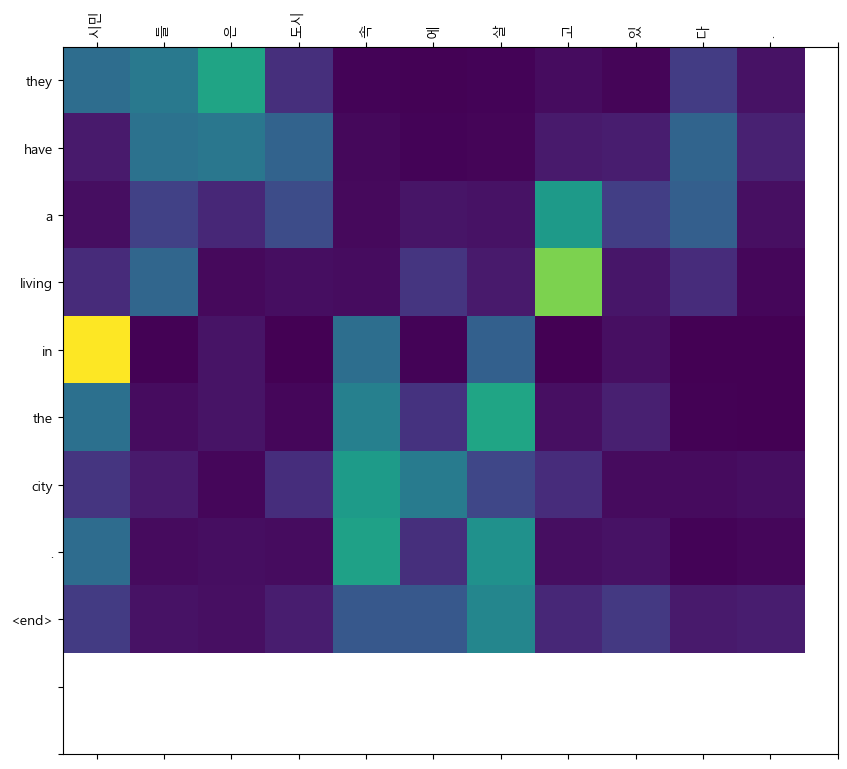

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: but you re just yet to be coffee <end> 


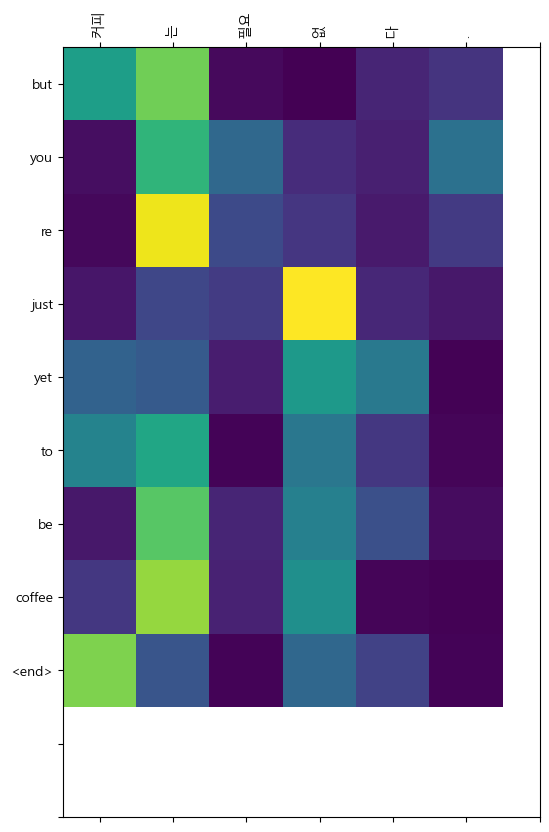

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven people were killed , three of the number is deaths . <end> 


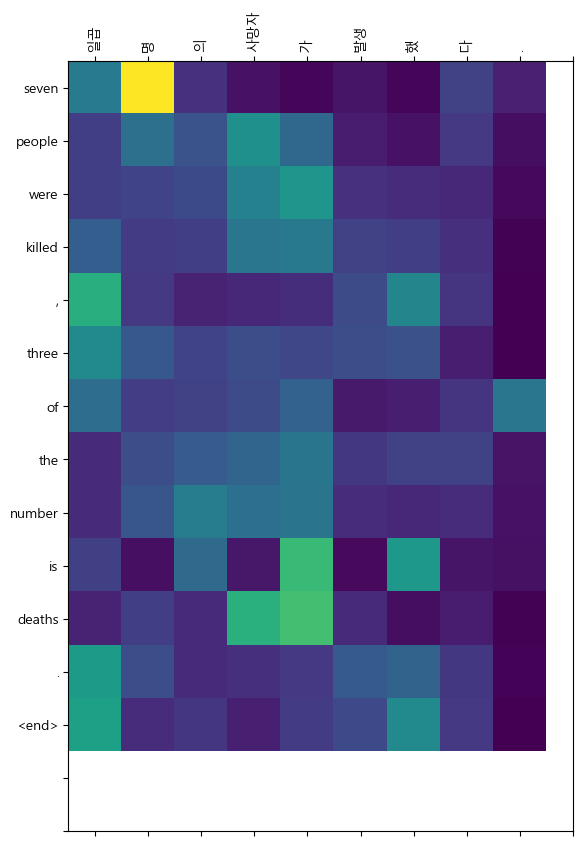

Epoch  2: 100%|███████████████████████████████████████████████████████| 1961/1961 [07:04<00:00,  4.62it/s, Loss 0.5686]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: about people fought in rural residents . <end> 


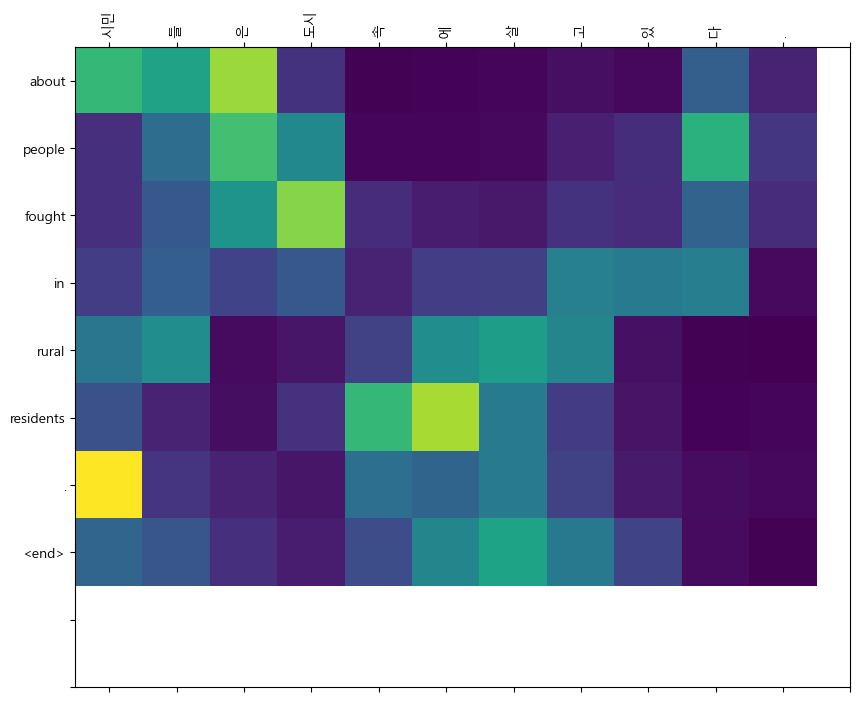

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: but you re not <end> 


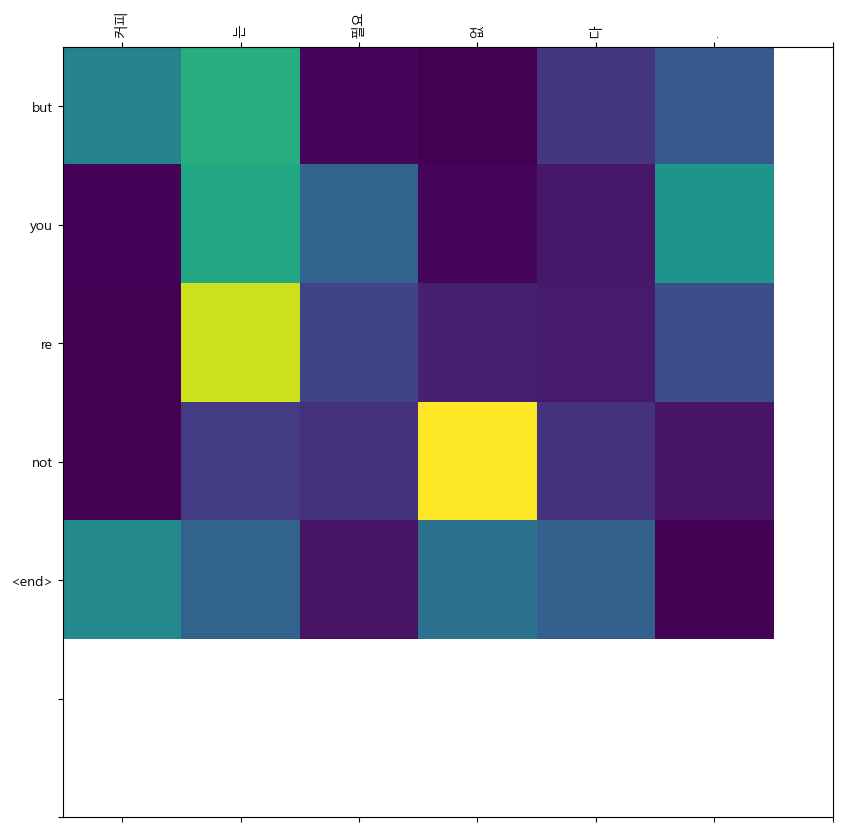

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven of those deaths have been killed , people died in the <unk> were also reported . <end> 


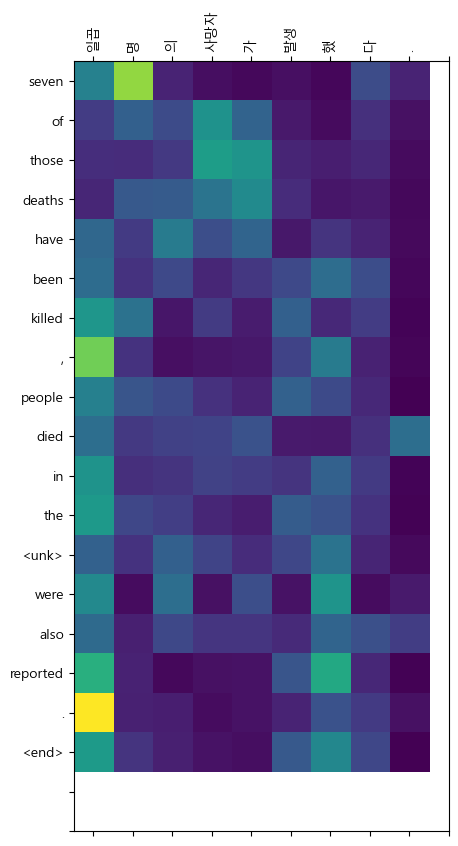

Epoch  3: 100%|███████████████████████████████████████████████████████| 1961/1961 [07:03<00:00,  4.63it/s, Loss 0.5431]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: they have a year . <end> 


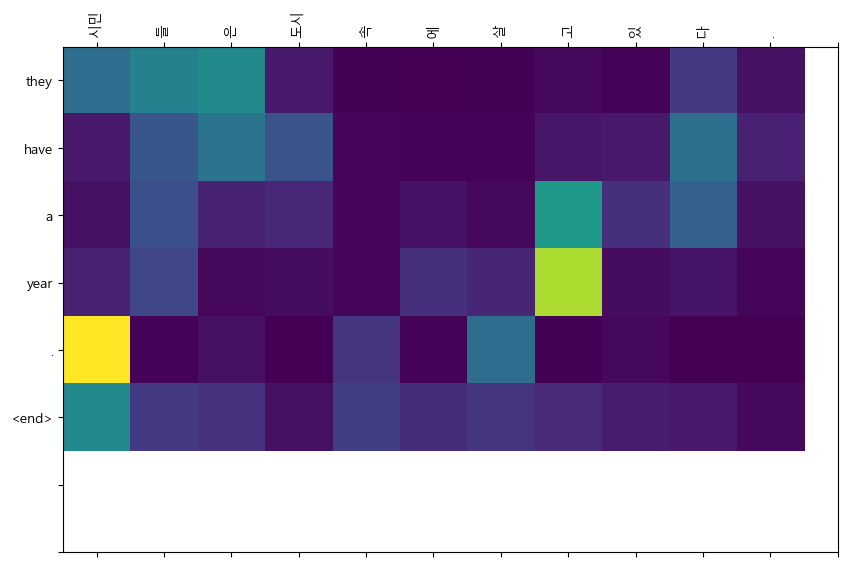

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the computing might cause coffee <end> 


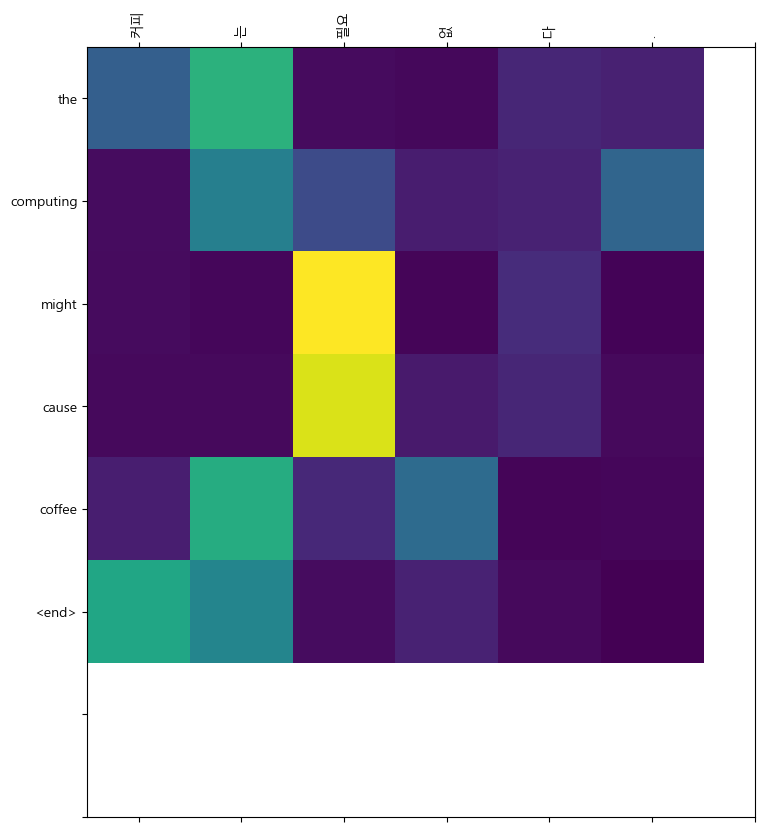

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven were killed , people died . <end> 


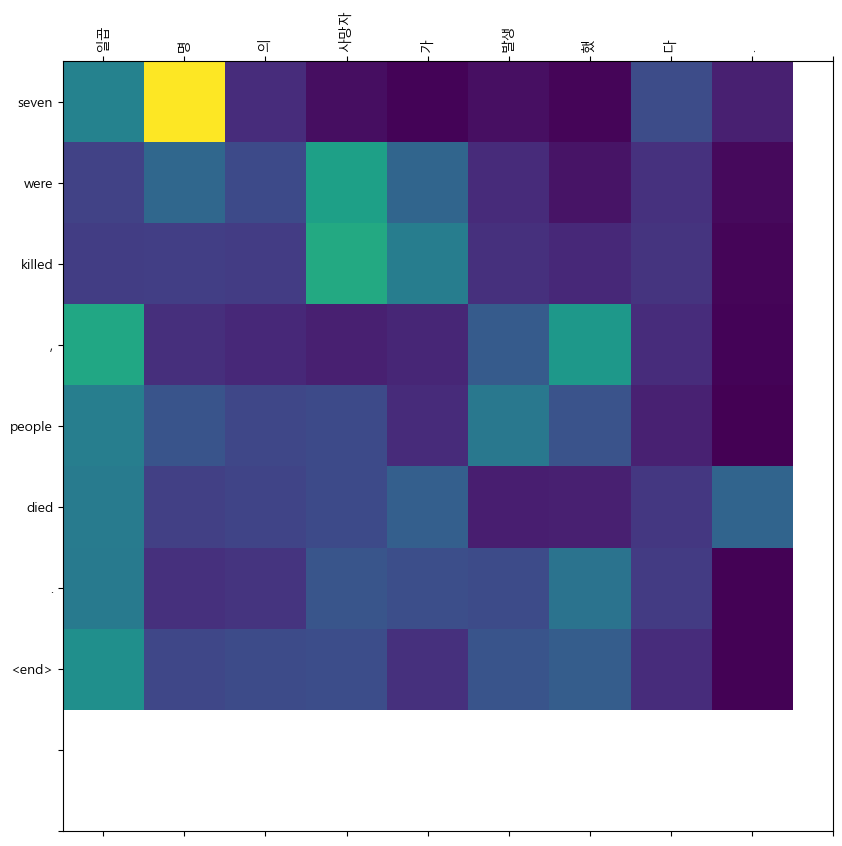

Epoch  4: 100%|███████████████████████████████████████████████████████| 1961/1961 [07:04<00:00,  4.62it/s, Loss 0.5212]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: they have lived in the city . <end> 


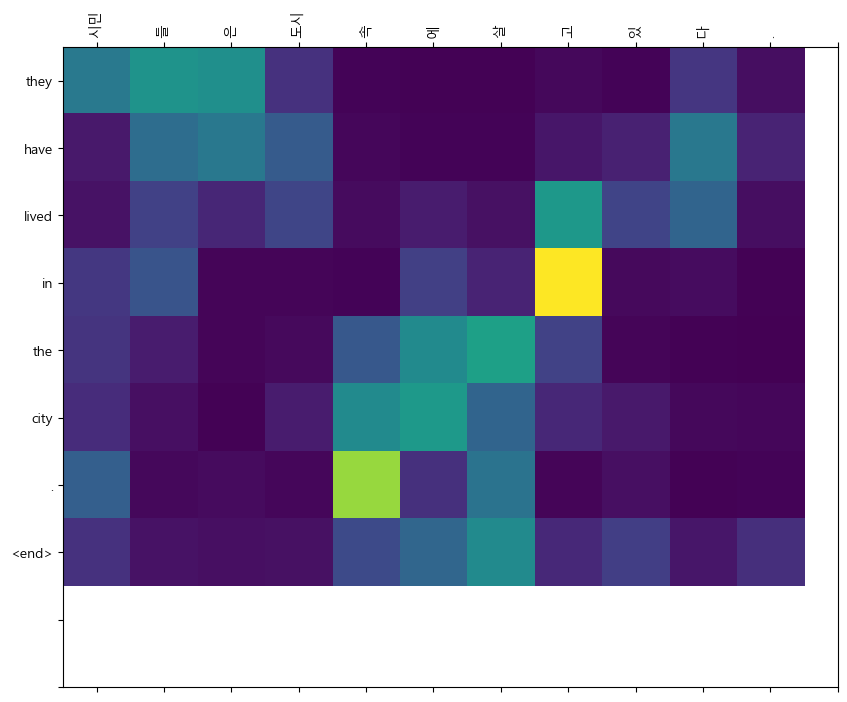

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: it s not just to be on the coffee thing . <end> 


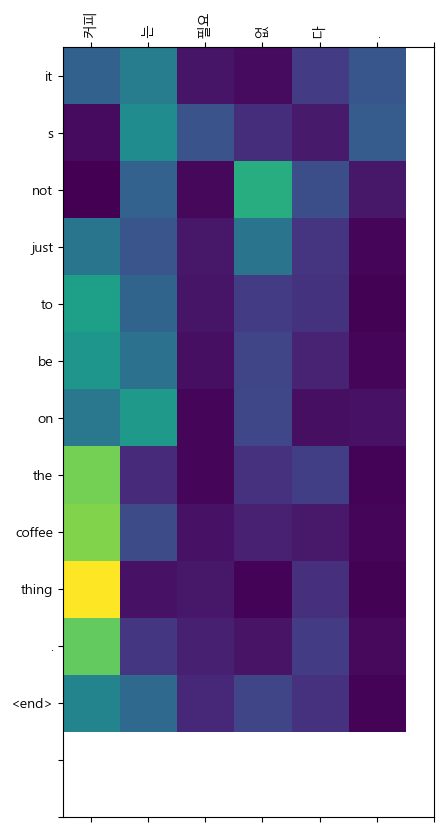

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven people were injured , mostly died . <end> 


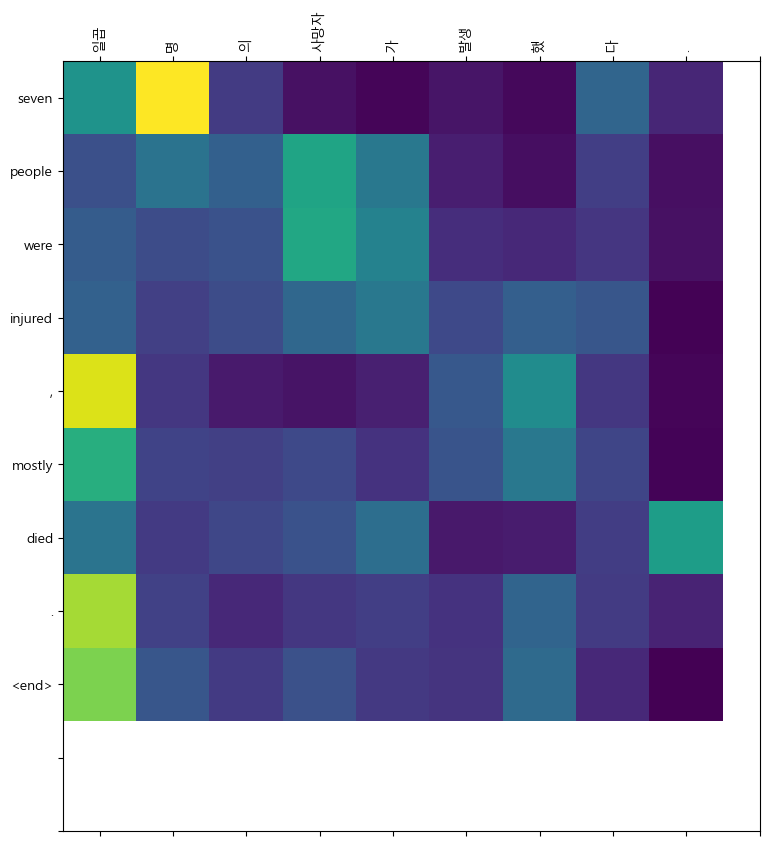

Epoch  5: 100%|███████████████████████████████████████████████████████| 1961/1961 [07:01<00:00,  4.65it/s, Loss 0.5102]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: they have a living in rural schools . <end> 


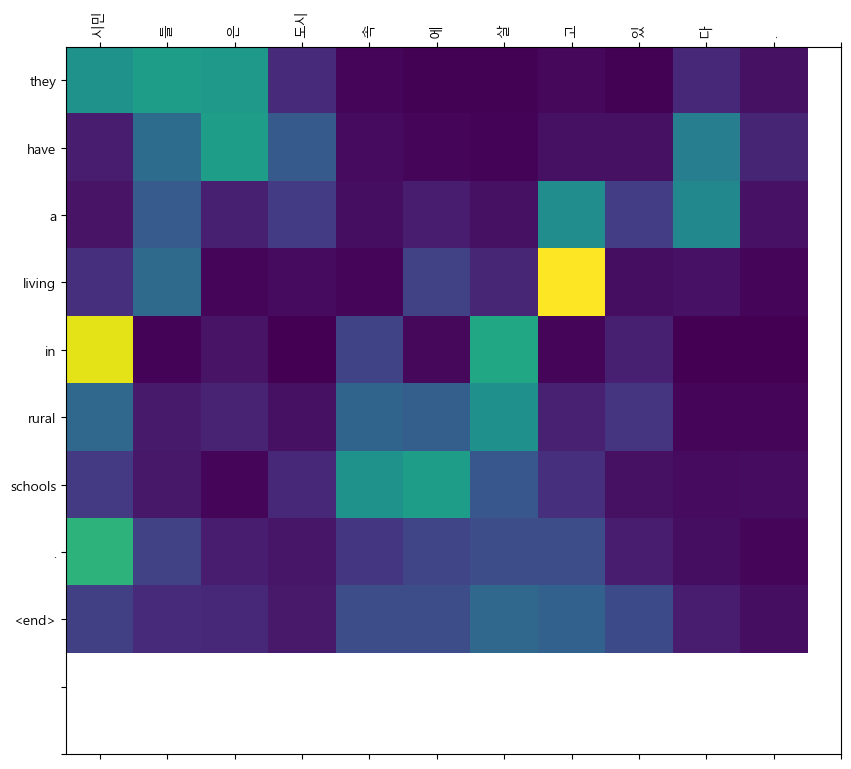

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the question isn t just still there is no . <end> 


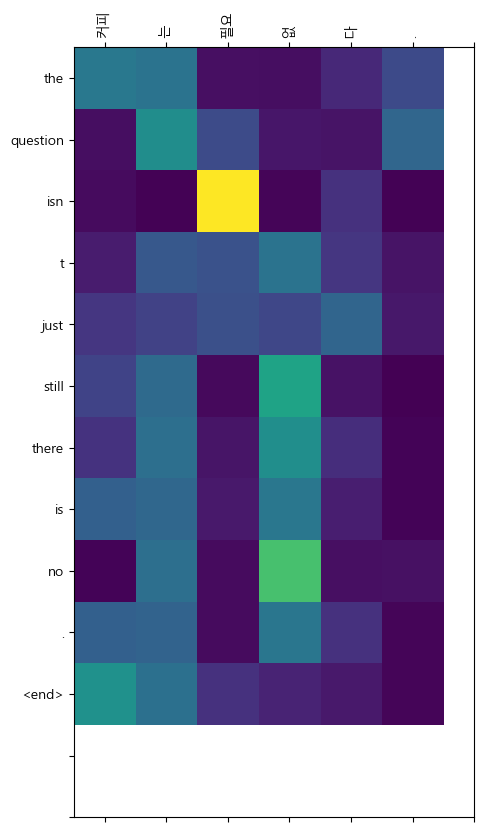

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven deaths , people have died in the <unk> clash . <end> 


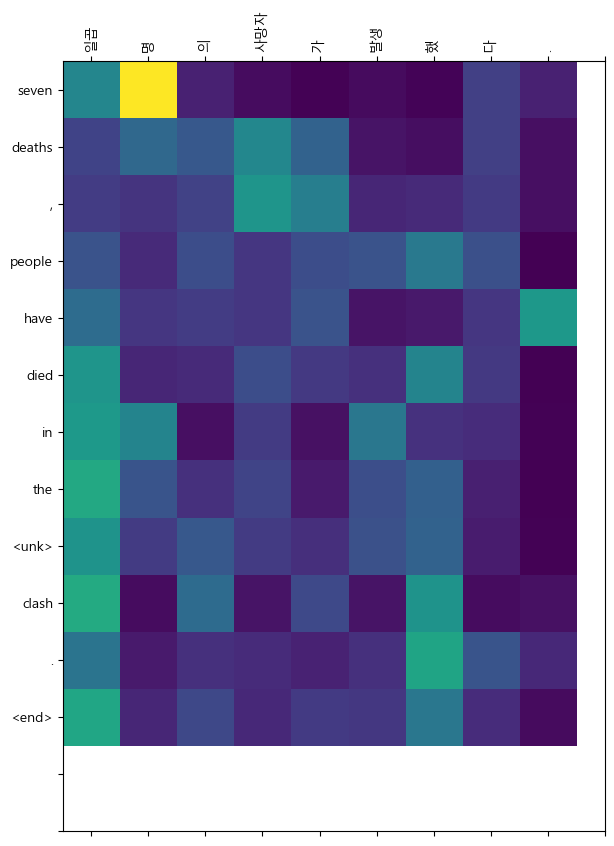

Epoch  6: 100%|███████████████████████████████████████████████████████| 1961/1961 [07:02<00:00,  4.64it/s, Loss 0.5054]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: about , people in the city is a year . <end> 


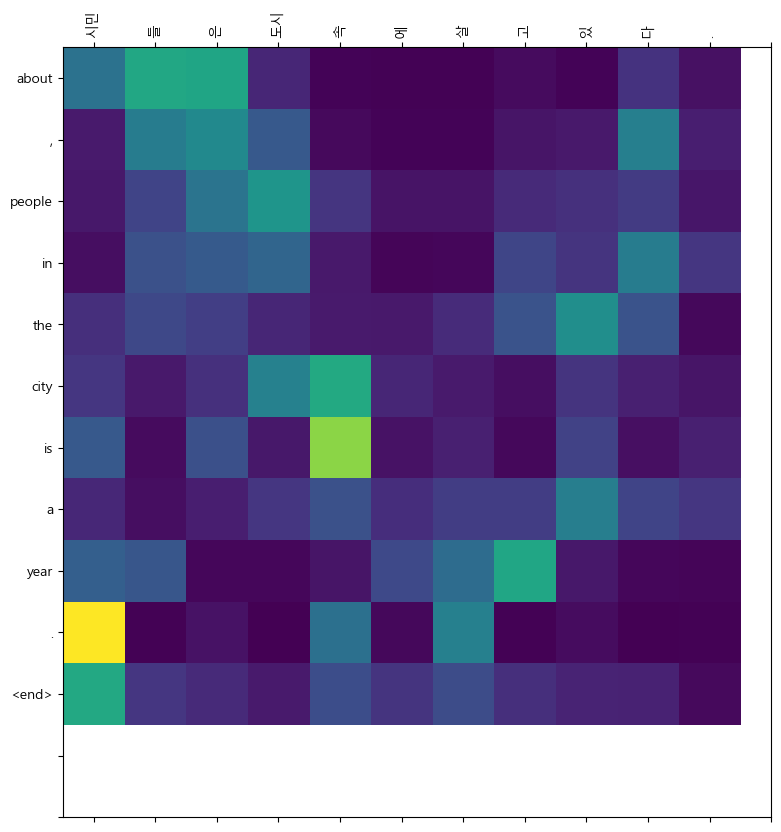

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the value allows it is no danger . <end> 


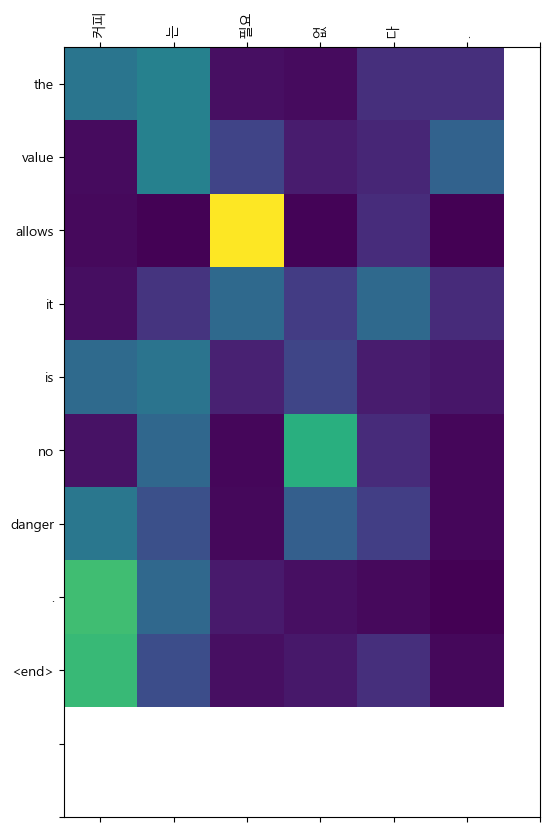

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: more were killed , people died of them seven deaths had been injured . <end> 


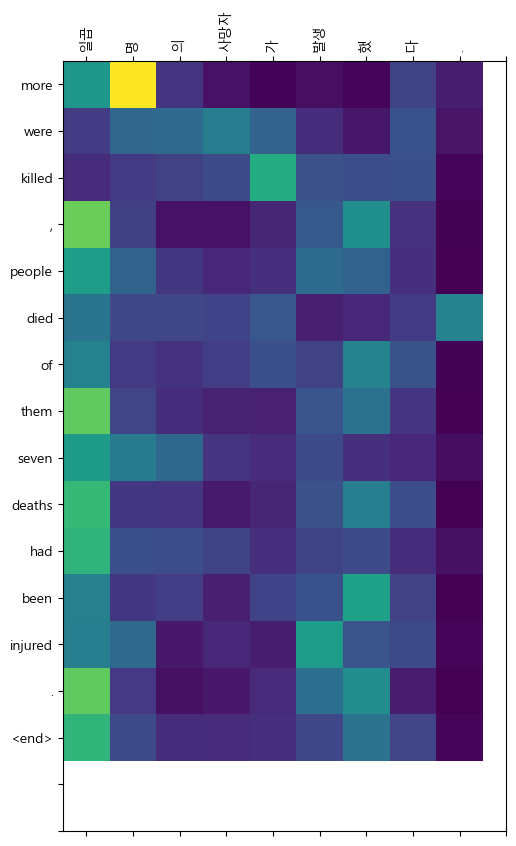

Epoch  7: 100%|███████████████████████████████████████████████████████| 1961/1961 [06:58<00:00,  4.68it/s, Loss 0.4952]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: they know this city <end> 


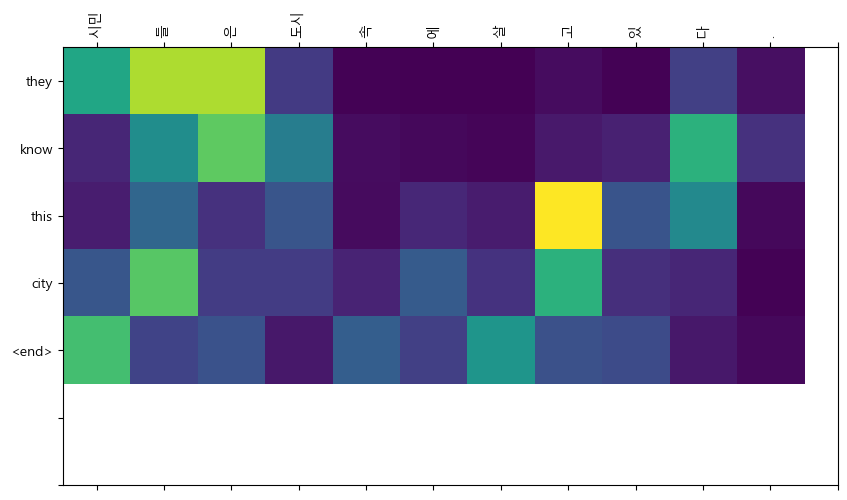

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: but you re not ask <end> 


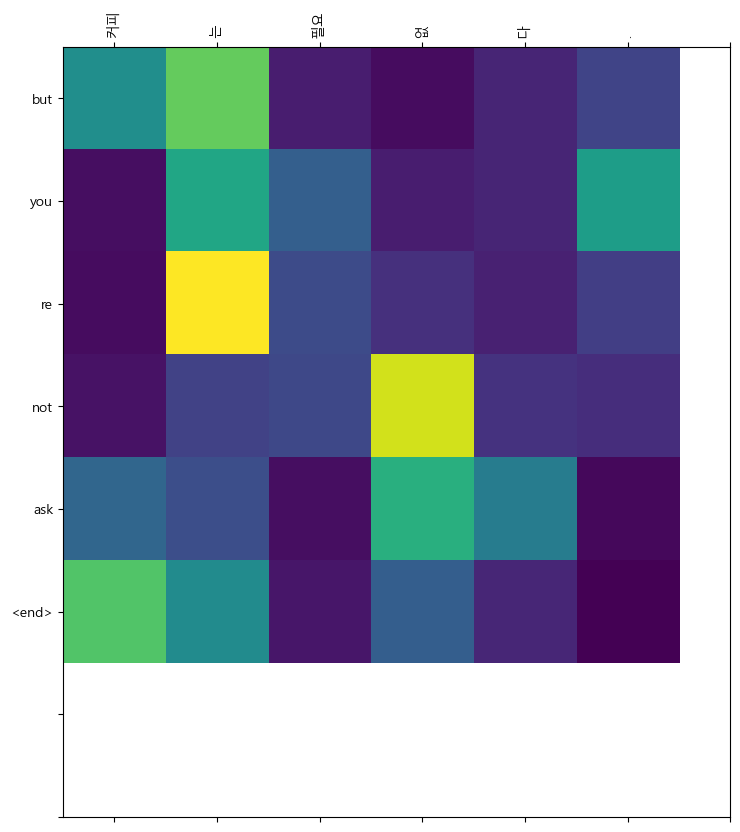

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven were killed , people have died . <end> 


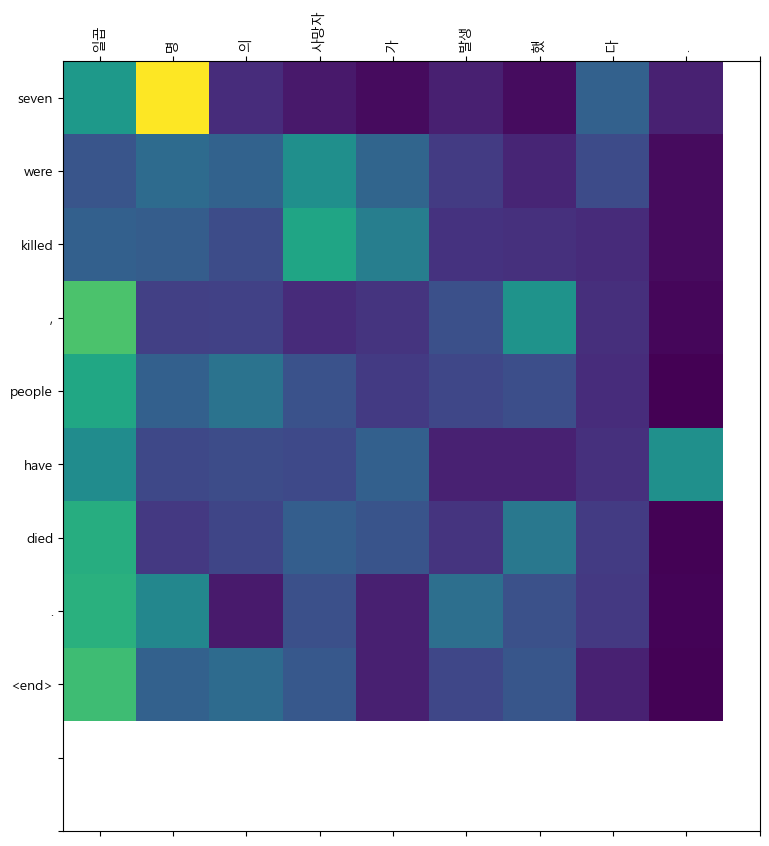

Epoch  8: 100%|███████████████████████████████████████████████████████| 1961/1961 [06:58<00:00,  4.69it/s, Loss 0.4898]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: they know , people in the city . <end> 


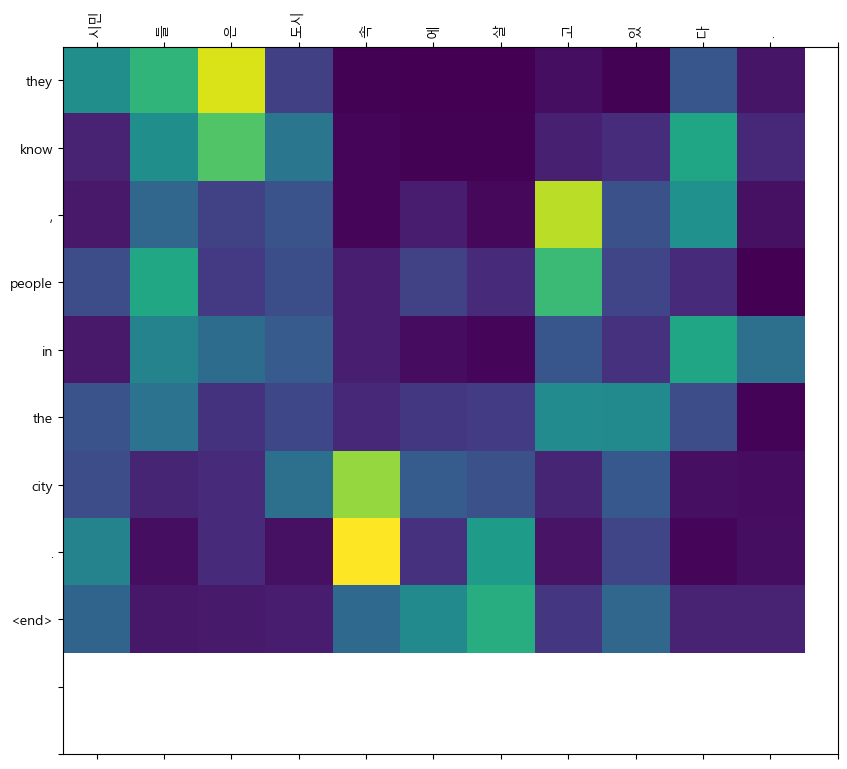

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the experts also says there really think it s possible . <end> 


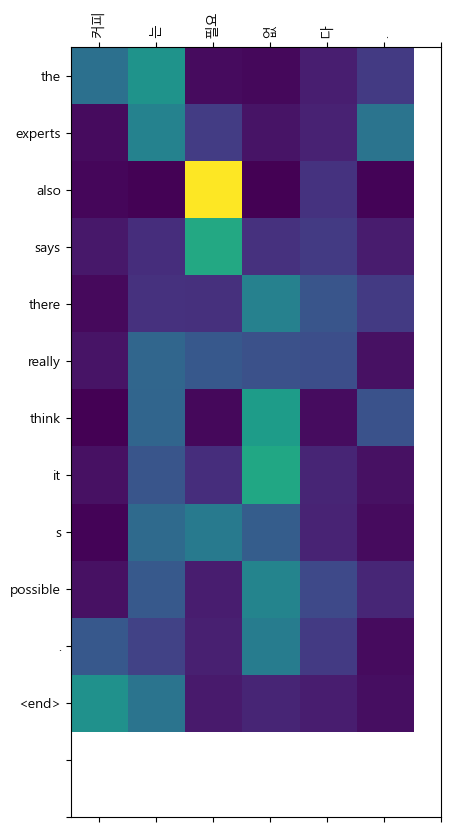

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven were killed , people and two of the <unk> died . <end> 


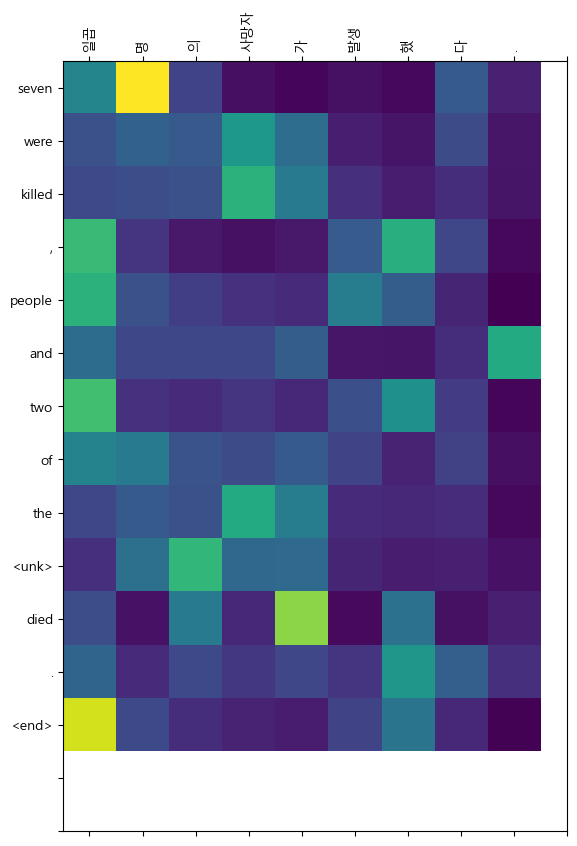

Epoch  9: 100%|███████████████████████████████████████████████████████| 1961/1961 [06:57<00:00,  4.70it/s, Loss 0.4857]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: villagers have been living in rural residents . <end> 


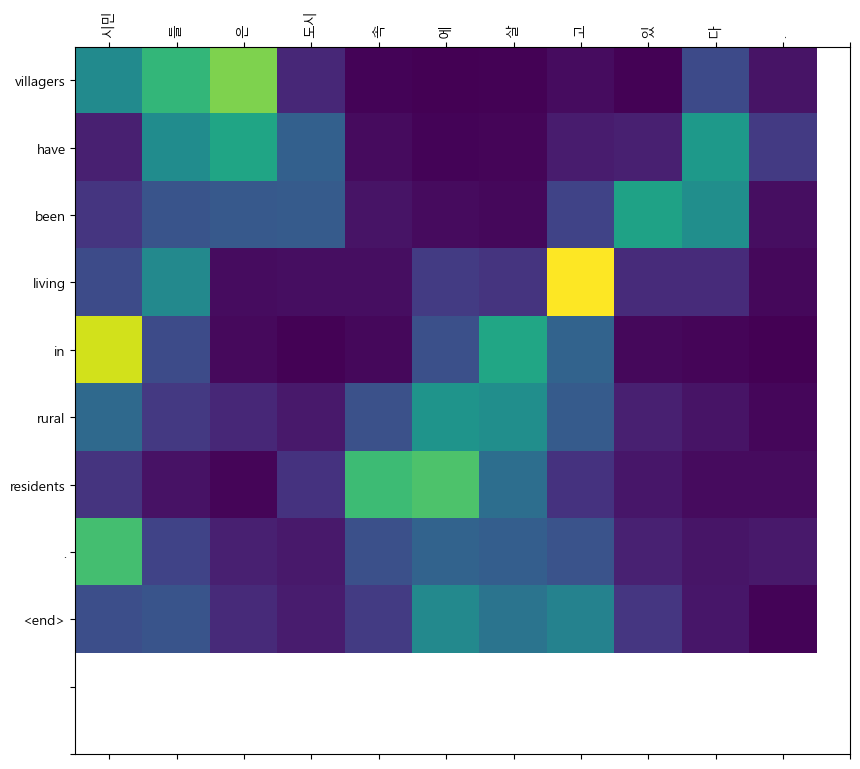

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the drink changes should be on instead of coffee <end> 


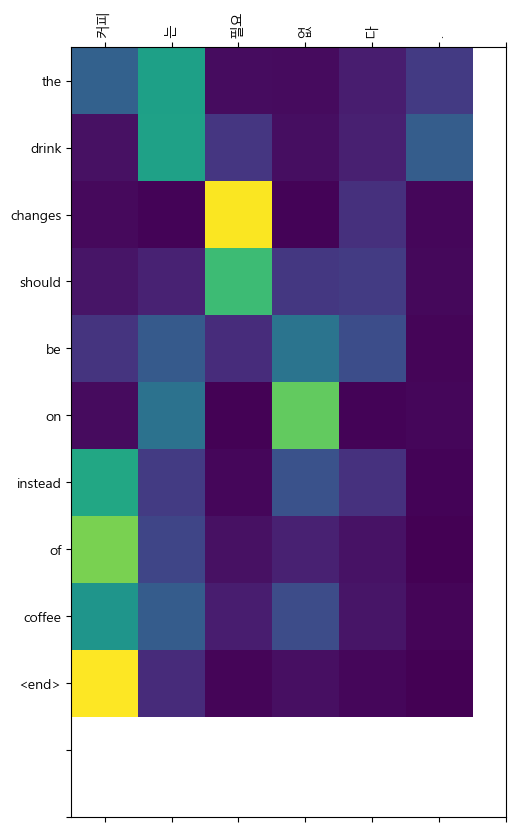

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven people were also died , who was killed . <end> 


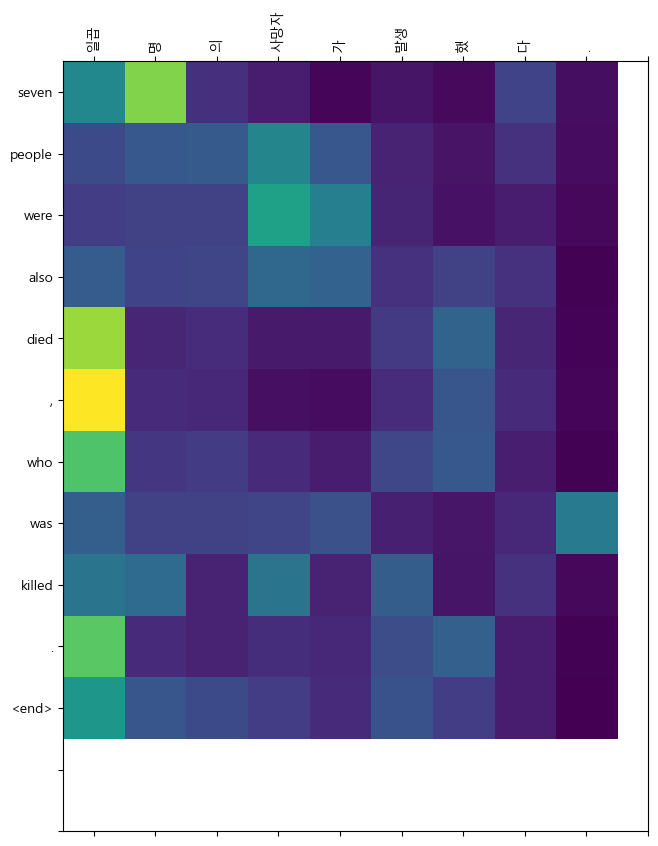

Epoch 10: 100%|███████████████████████████████████████████████████████| 1961/1961 [06:56<00:00,  4.71it/s, Loss 0.4814]


Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: they have a living in rural as many people live to cities on the beach <end> 


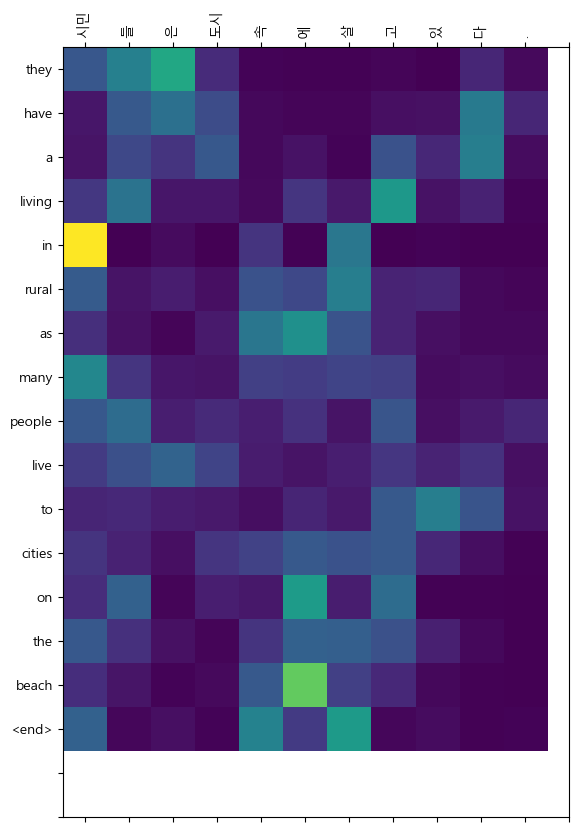

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the experts tax fears is not too much for <end> 


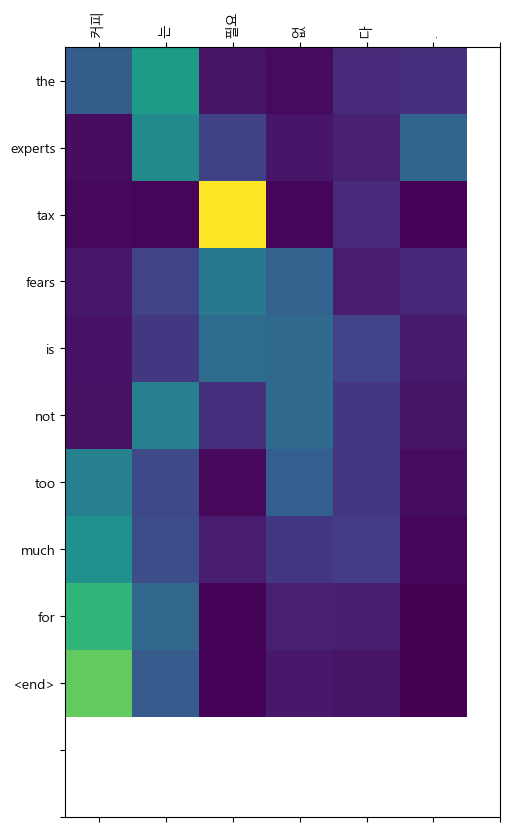

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven were killed , eight died in numbers have been rescued . <end> 


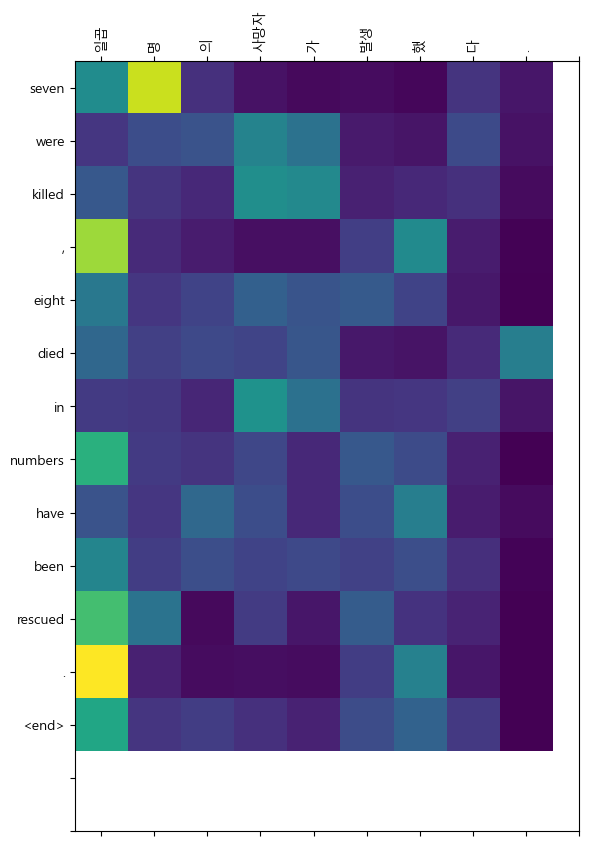

In [65]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10
history = []

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_corpus.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_corpus[idx:idx+BATCH_SIZE],
                                eng_corpus[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                en_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
        
    history.append(total_loss.numpy() / (batch + 1))
    translate("시민들은 도시 속에 살고 있다.", encoder, decoder)
    translate("커피는 필요 없다.", encoder, decoder)
    translate("일곱 명의 사망자가 발생했다.", encoder, decoder)
    

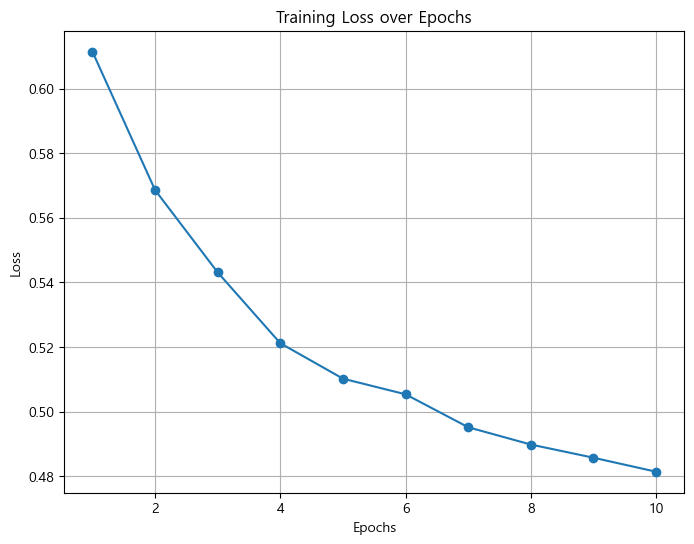

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS + 1), history, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

Input: ['시민', '들', '은', '도시', '속', '에', '살', '고', '있', '다', '.']
Predicted translation: they have a living in rural as many people live to cities on the beach <end> 


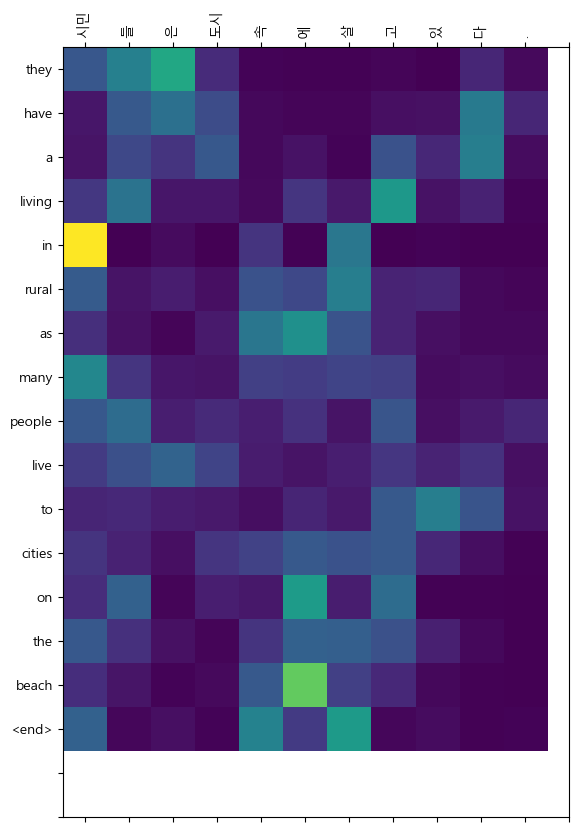

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the experts tax fears is not too much for <end> 


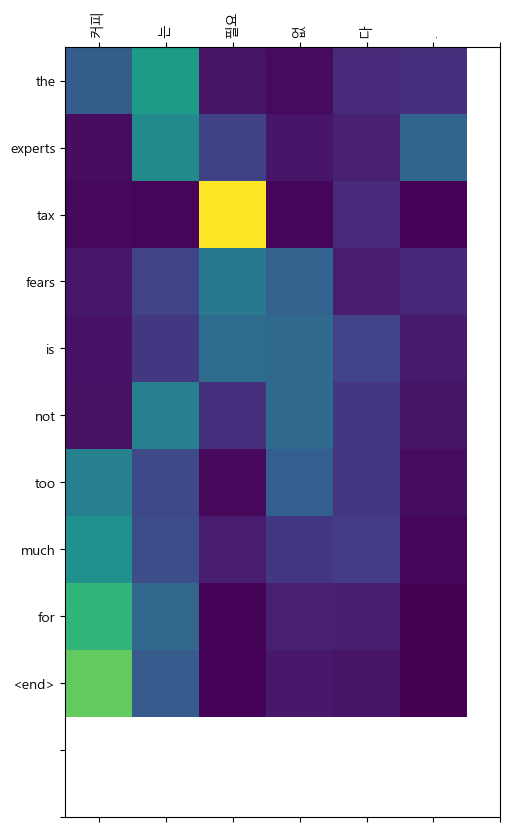

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven were killed , eight died in numbers have been rescued . <end> 


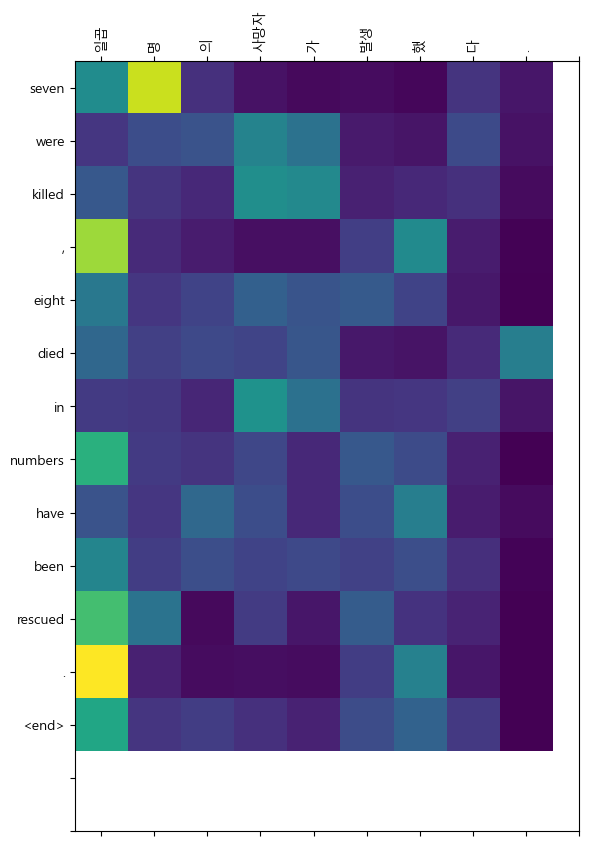

In [67]:
translate("시민들은 도시 속에 살고 있다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)